In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid

In [2]:
def outlierInfo(data,IQR_factor):
    
    print(f'Number of data points: {np.count_nonzero(data)}')

    # Calculate Q1 and Q3 using np.nanpercentile to ignore NaN values
    min = np.nanmin(data)
    Q1 = np.nanpercentile(data, 25)
    med = np.nanpercentile(data, 50)
    Q3 = np.nanpercentile(data, 75)
    max = np.nanmax(data)
    
    mean = np.nanmean(data)
    std = np.nanstd(data)
    print(f'min = {min}')
    print(f'Q1 = {Q1}')
    print(f'median = {med}')
    print(f'Q3 = {Q3}')
    print(f'max = {max}\n')

    print(f'mean = {mean}')
    print(f'std = {std}\n')

    # Compute IQR
    IQR = Q3 - Q1

    print(f'IQR = {IQR}')

    print(f'Outlier Criteria: {IQR_factor}*IQR')

    # Determine bounds
    lower_bound = Q1 - IQR_factor * IQR
    upper_bound = Q3 + IQR_factor * IQR

    # Remove NaN values from data before filtering for outliers to avoid comparison with NaN
    clean_data = data[~np.isnan(data)]

    # Filter data to remove outliers
    filtered_data = clean_data[(clean_data >= lower_bound) & (clean_data <= upper_bound)]

    # Determine the number of outliers removed
    num_outliers_removed = len(clean_data) - len(filtered_data)

    print(f"Number of outliers removed: {num_outliers_removed}")

In [3]:
AB_wildfire2006 = pd.read_excel('fp-historical-wildfire-data-2006-2021.xlsx')
#AB_wildfire2006.at[605,'fire_start_date'] = '04/24/2021 12:00:00'
#AB_wildfire2006.at[13948,'fire_start_date'] = '10/06/2011 23:18:00'

In [4]:
wildfires_df = pd.read_csv("processed_wildfire_df.csv")
wildfires_df.info()
#wildfires_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33149 entries, 0 to 33148
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    33149 non-null  int64  
 1   id                            33149 non-null  int64  
 2   fire_number                   33149 non-null  object 
 3   year                          33149 non-null  int64  
 4   discovered_date               30159 non-null  object 
 5   date                          33149 non-null  object 
 6   detection_agent_type          33149 non-null  object 
 7   smoke_type                    12599 non-null  object 
 8   smoke_color                   12849 non-null  object 
 9   smoke_base_size               12115 non-null  object 
 10  condition_of_smoke            8054 non-null   object 
 11  latitude                      33149 non-null  float64
 12  longitude                     33149 non-null  float64
 13  d

In [5]:
AB_wildfire2006.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22914 entries, 0 to 22913
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   fire_year                     22914 non-null  int64         
 1   fire_number                   22914 non-null  object        
 2   fire_name                     604 non-null    object        
 3   current_size                  22914 non-null  float64       
 4   size_class                    22914 non-null  object        
 5   fire_location_latitude        22914 non-null  float64       
 6   fire_location_longitude       22914 non-null  float64       
 7   fire_origin                   22905 non-null  object        
 8   general_cause_desc            22914 non-null  object        
 9   industry_identifier_desc      408 non-null    object        
 10  responsible_group_desc        9031 non-null   object        
 11  activity_class              

In [6]:
# To test if features are the same in the cleaned and raw dataset (to find out which column is which feature in the Alberta webiste documentation)
#AB_wildfire2006[(AB_wildfire2006['fire_number']=='CWF001') & (AB_wildfire2006['fire_year']==2006)]['true_cause']
#wildfires_df[(wildfires_df['fire_number']=='CWF001') & (wildfires_df['year']==2006)]['general_cause']

In [7]:
#outlierInfo(wildfires_df['date'],1.5)
#wildfires_df['longitude'].describe()
wildfires_df['general_cause'].unique()

array(['Resident', 'Lightning', 'Miscellaneous Known', 'Other Industry',
       'Undetermined', 'Forest Industry', 'Recreation', 'Incendiary',
       'Railroad', 'Power Line Industry', 'Restart', 'Oil & Gas Industry',
       'Agriculture Industry', 'Government', 'Under Investigation'],
      dtype=object)

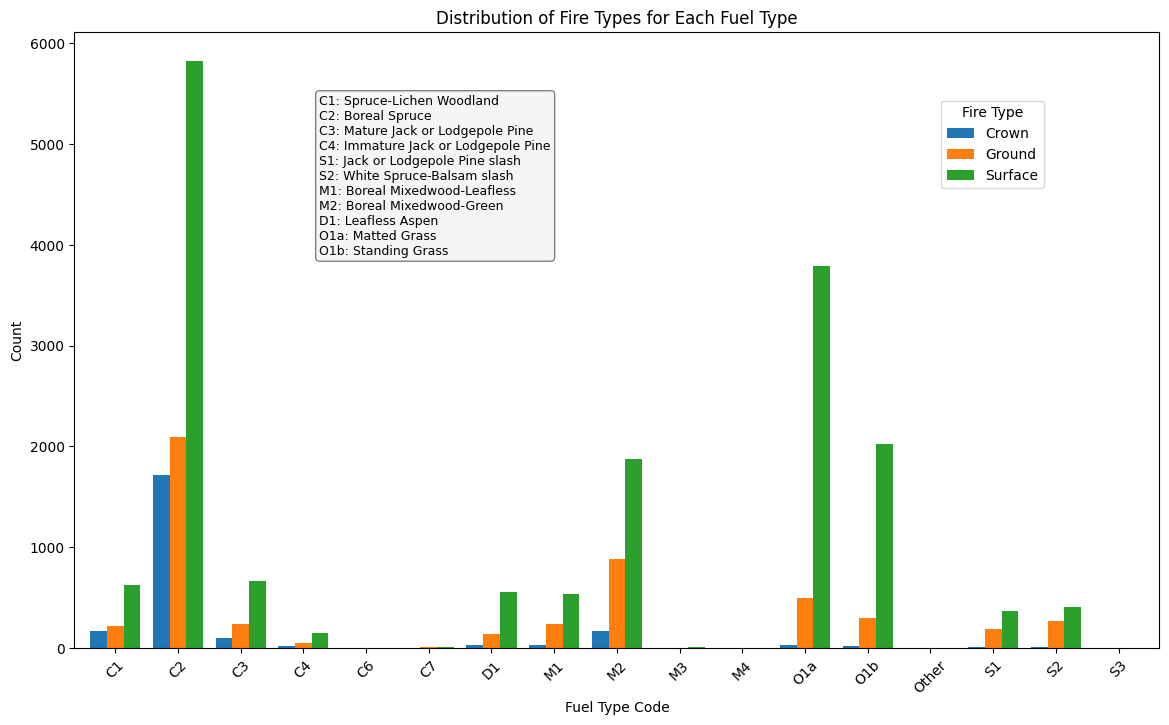

In [26]:
# Clean 'fire_type' column to remove leading spaces
wildfires_df['fire_type'] = wildfires_df['fire_type'].str.strip()

# Filter out rows where 'fuel_type' is NaN
wildfires_df = wildfires_df.dropna(subset=['fuel_type'])

# Remove leading/trailing spaces from 'fuel_type' and map ' ' to 'Other'
wildfires_df['fuel_type'] = wildfires_df['fuel_type'].str.strip().replace('', 'Other')

# Fuel type definitions, excluding the ' ' mapping
fuel_type_definitions = {
    'C1': 'Spruce-Lichen Woodland',
    'C2': 'Boreal Spruce',
    'C3': 'Mature Jack or Lodgepole Pine',
    'C4': 'Immature Jack or Lodgepole Pine',
    'S1': 'Jack or Lodgepole Pine slash',
    'S2': 'White Spruce-Balsam slash',
    'M1': 'Boreal Mixedwood-Leafless',
    'M2': 'Boreal Mixedwood-Green',
    'D1': 'Leafless Aspen',
    'O1a': 'Matted Grass',
    'O1b': 'Standing Grass',
    'Other': 'Other'  # Mapping for 'Other' directly included
}

# Count occurrences of each fire type within each fuel type
count_df = wildfires_df.groupby(['fuel_type', 'fire_type']).size().unstack(fill_value=0)

# Plot a grouped bar chart
count_df.plot(kind='bar', figsize=(14, 8), width=0.8)

plt.title('Distribution of Fire Types for Each Fuel Type')
plt.xlabel('Fuel Type Code')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust fire type legend position within the plot area
plt.legend(title='Fire Type', loc='upper right', bbox_to_anchor=(0.9, 0.9))

# Prepare and add the additional legend for fuel type definitions within the plot area, excluding 'Other'
fuel_type_legend = [f'{code}: {desc}' for code, desc in fuel_type_definitions.items() if code != 'Other']
plt.figtext(0.3, 0.7, "\n".join(fuel_type_legend), ha='left', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='whitesmoke'))

plt.show()

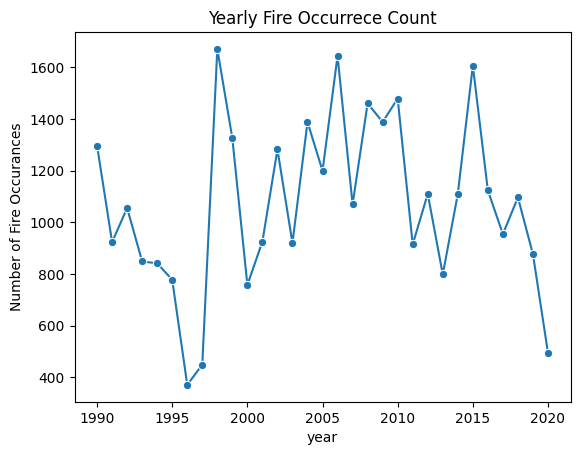

In [17]:
Yearly_occurances = wildfires_df.groupby('year').size()
sns.lineplot(Yearly_occurances, marker='o')
plt.ylabel('Number of Fire Occurances')
plt.title('Yearly Fire Occurrece Count')
plt.grid(False)

C:\Users\Chis\AppData\Local\Temp\ipykernel_7212\2317742049.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")


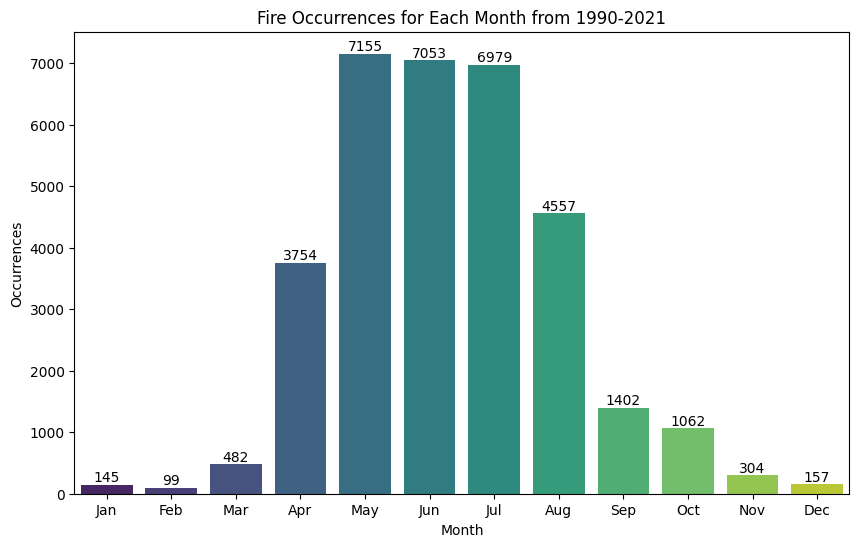

In [14]:
wildfires_df['date'] = pd.to_datetime(wildfires_df['date'])

# Extract month and map it to month names
wildfires_df['month'] = wildfires_df['date'].dt.month_name().str[:3]

# Count occurrences for each month
month_counts = wildfires_df['month'].value_counts().sort_index()

# Create a month order mapping to ensure months are displayed in calendar order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = month_counts.reindex(month_order)

# Plot the counts using seaborn's barplot for better style control
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=month_counts.index, y=month_counts.values, palette="viridis")

# Annotate each bar with its count
for index, value in enumerate(month_counts.values):
    # Annotate the bar with the count
    plt.text(index, value, f'{value}', ha='center', va='bottom')

plt.title('Fire Occurrences for Each Month from 1990-2021')
plt.xlabel('Month')
plt.ylabel('Occurrences')

plt.show()

C:\Users\Chis\AppData\Local\Temp\ipykernel_30916\3719537138.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Count', y='General Cause', data=cause_counts, palette='pastel')


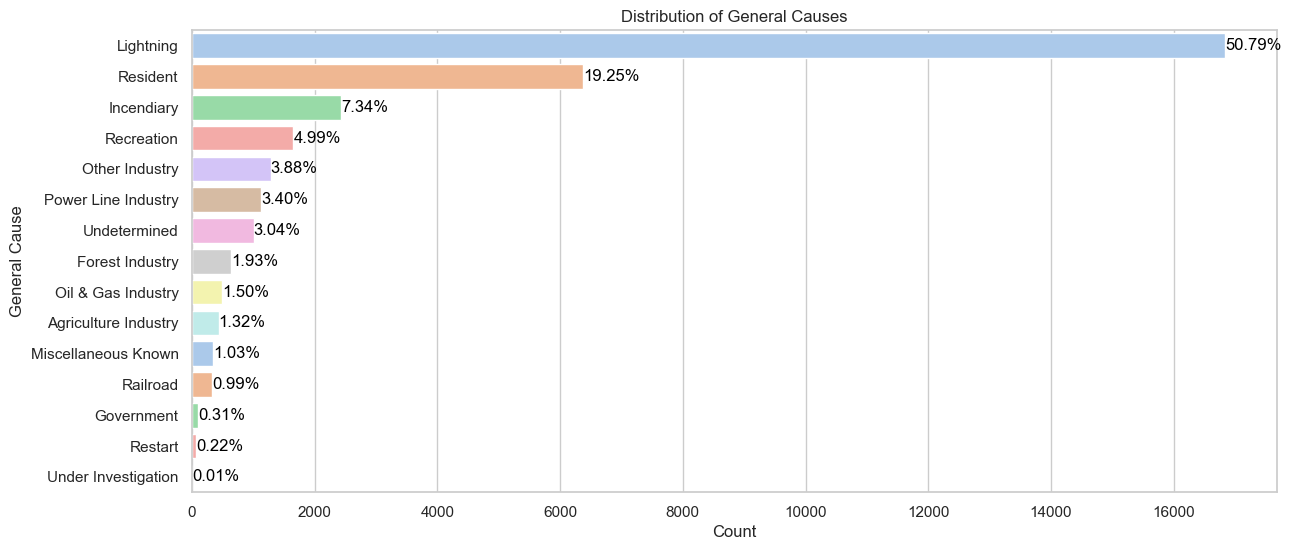

In [10]:
cause_counts = wildfires_df['general_cause'].value_counts().reset_index()
cause_counts.columns = ['General Cause', 'Count']

total_count = cause_counts['Count'].sum()

# Calculate the percentage of each category
cause_counts['Percentage'] = (cause_counts['Count'] / total_count) * 100

# Create a bar chart using Seaborn
sns.set(style="whitegrid")  # Set the Seaborn style
plt.figure(figsize=(14, 6))  # Set the figure size (optional)
barplot = sns.barplot(x='Count', y='General Cause', data=cause_counts, palette='pastel')

plt.title('Distribution of General Causes')
plt.xlabel('Count')
plt.ylabel('General Cause')

# Add percentage text inside each bar
for index, row in cause_counts.iterrows():
    barplot.text(row.Count, index, f'{row.Percentage:.2f}%', color='black', va="center")

# Show the plot
plt.show()

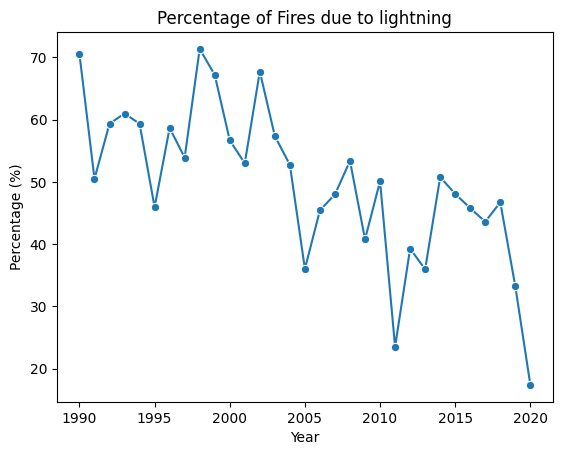

In [16]:
# Group by 'year' and calculate the percentage of 'Lightning' for each year
lightning_percent_by_year = wildfires_df.groupby('year')['general_cause'].apply(
    lambda x: (x == 'Lightning').mean() * 100
).reset_index(name='percentage')

# Plot the line chart
sns.lineplot(data=lightning_percent_by_year, x='year', y='percentage', marker='o')
plt.title("Percentage of Fires due to lightning")
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.grid(False)

# Show the plot
plt.show()

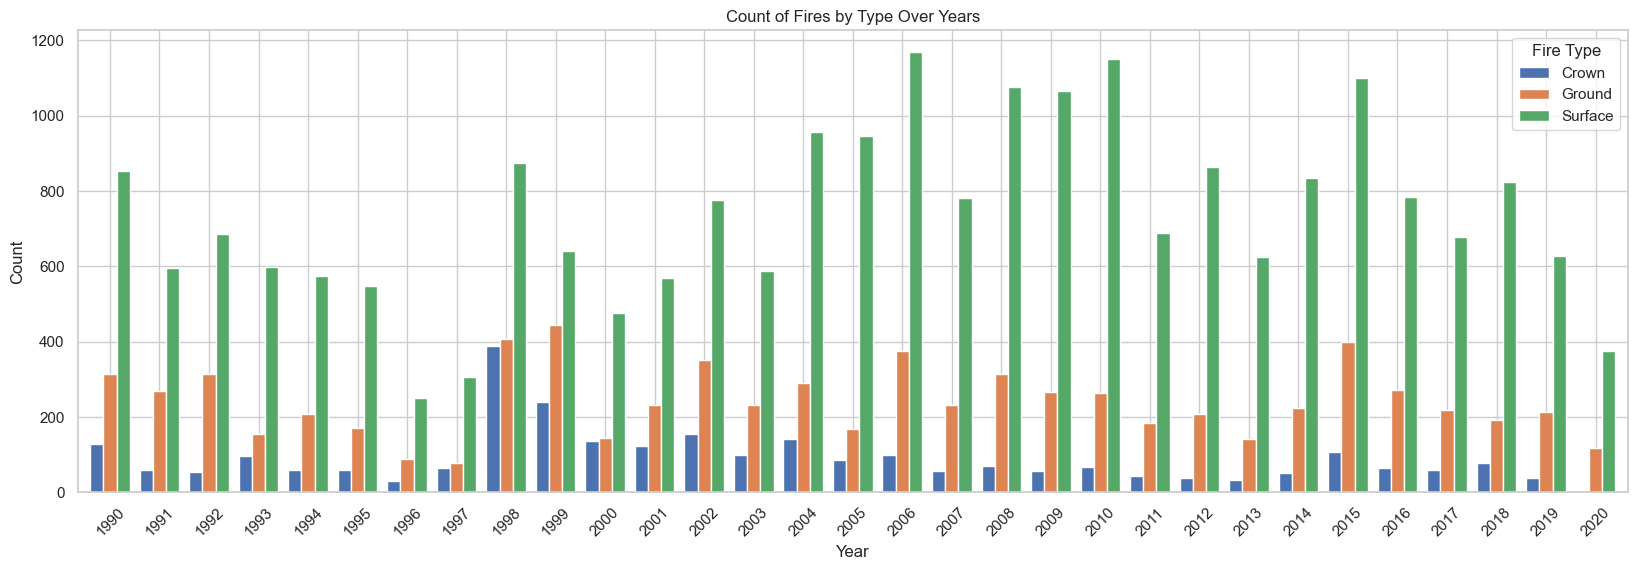

In [17]:
# Remove leading and trailing spaces from 'fire_type'
wildfires_df['fire_type'] = wildfires_df['fire_type'].str.strip()

# Filter out the year 2021
wildfires_df = wildfires_df[wildfires_df['year'] != 2021]

# Group by 'year' and 'fire_type', then count occurrences
fire_counts = wildfires_df.groupby(['year', 'fire_type']).size().unstack(fill_value=0)

# Create a grouped bar chart
fire_counts.plot(kind='bar', figsize=(20, 6), width=0.8)

plt.title('Count of Fires by Type Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Fire Type')

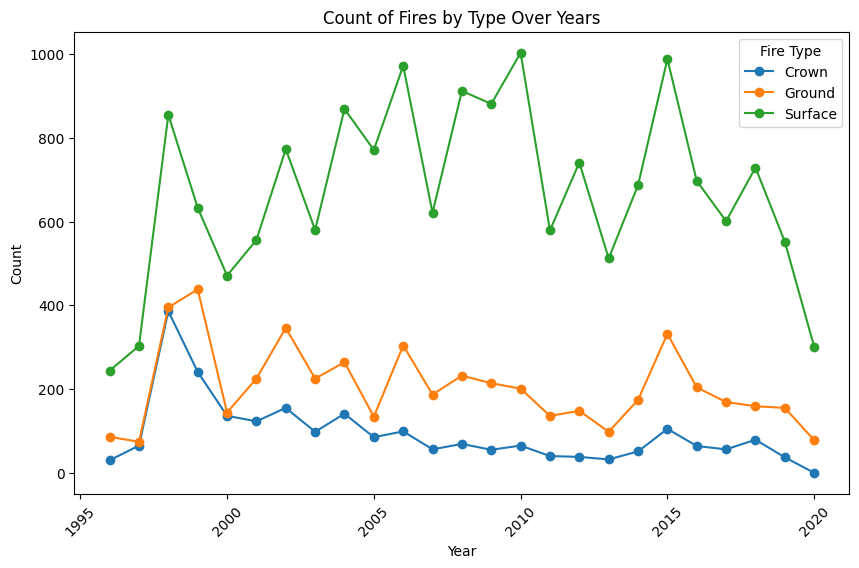

In [30]:
# Remove leading and trailing spaces from 'fire_type'
wildfires_df['fire_type'] = wildfires_df['fire_type'].str.strip()

# Filter out the year 2021
wildfires_df = wildfires_df[wildfires_df['year'] != 2021]

# Group by 'year' and 'fire_type', then count occurrences
fire_counts = wildfires_df.groupby(['year', 'fire_type']).size().unstack(fill_value=0)

# Create a line plot
fire_counts.plot(kind='line', figsize=(10, 6), marker='o')

plt.title('Count of Fires by Type Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Fire Type')

plt.grid(False)  # Optional: Adds a grid for easier reading of the plot
plt.show()

Statistical summary for the number of fires per day:
count    4314.000000
mean        5.623319
std         9.101750
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       133.000000
dtype: float64


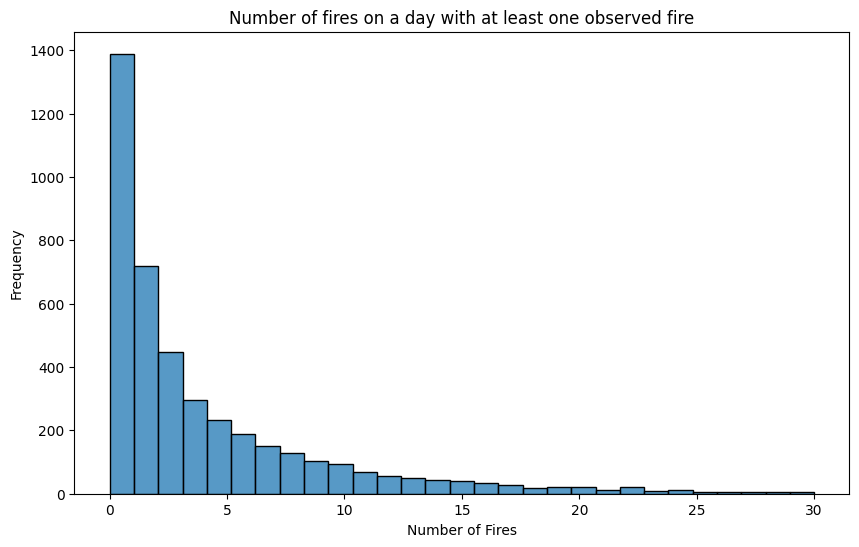

In [48]:
# Convert 'date' column to datetime, focusing on the date only
wildfires_df['date'] = pd.to_datetime(wildfires_df['date']).dt.date

# Count the number of fires on each day
fires_per_day = wildfires_df.groupby('date').size()

# Calculate and display statistical summary for the number of fires per day
print("Statistical summary for the number of fires per day:")
print(fires_per_day.describe())

# Distribution plot for the number of fires on each day
plt.figure(figsize=(10, 6))
sns.histplot(fires_per_day, bins=29, binrange=[0, 30])
plt.title('Number of fires on a day with at least one observed fire')
plt.xlabel('Number of Fires')
plt.ylabel('Frequency')
plt.show()

C:\Users\Chis\AppData\Local\Temp\ipykernel_7212\979854997.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distances_by_day = wildfires_df.groupby('date').apply(pairwise_distances)


Statistical summary of distances between fires on the same day (in km):
count    469216.000000
mean        258.603469
std         173.408187
min           0.000399
25%         122.193168
50%         231.537860
75%         369.095106
max        1205.991422
dtype: float64


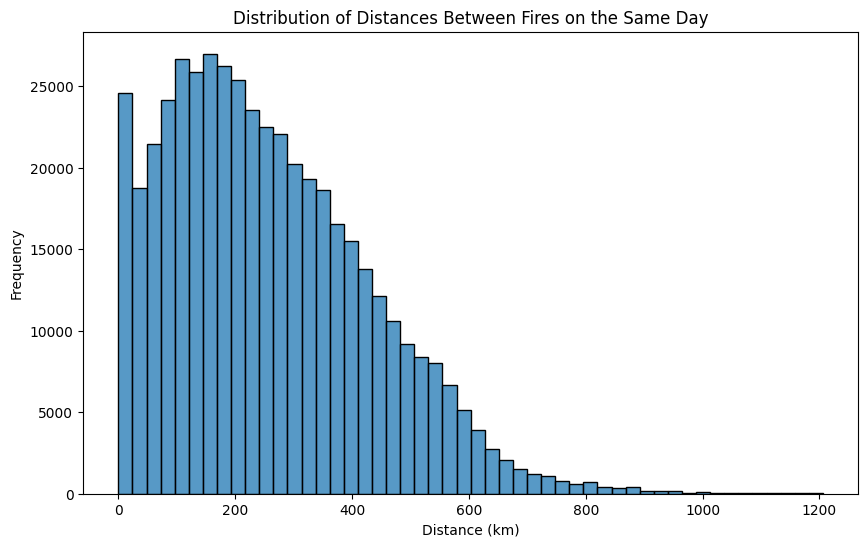

In [34]:
from scipy.spatial.distance import pdist, squareform
from haversine import haversine

# Function to calculate pairwise distances using the Haversine formula
def pairwise_distances(group):
    coords = group[['latitude', 'longitude']]
    if len(coords) > 1:  # Ensure there are at least 2 points to calculate distance
        dist_matrix = pdist(coords, lambda u, v: haversine(u, v))
        dist_matrix_square = squareform(dist_matrix)
        return dist_matrix_square
    else:
        return np.array([])  # Return an empty array for groups with one row

# Group by date and apply the distance calculation function
wildfires_df['date'] = pd.to_datetime(wildfires_df['date']).dt.date
distances_by_day = wildfires_df.groupby('date').apply(pairwise_distances)

# Flatten the array of distance matrices to get all non-zero distances in a single array
all_distances = np.concatenate([np.ravel(day[day != 0]) for day in distances_by_day if day.size > 0])

# Calculate and display statistical summary
distances_series = pd.Series(all_distances)  # Convert to pandas Series for easy statistics
print("Statistical summary of distances between fires on the same day (in km):")
print(distances_series.describe())

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(all_distances, bins=50)
plt.title('Distribution of Distances Between Fires on the Same Day')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

Looking at FWI dataset vvv

In [8]:
ds = xr.open_dataset("FWI_dataset/fire_weather_index_2020.nc")
lat = ds.variables['Latitude'][:].values
lon = ds.variables['Longitude'][:].values
time = ds.variables['Time'][:].values
FWI = ds.variables['FWI'][:].values

FWI_shifted, lon_shifted = shiftgrid(180.0, FWI[180, :, :], lon, start=False)

lons, lats = np.meshgrid(lon_shifted, lat)

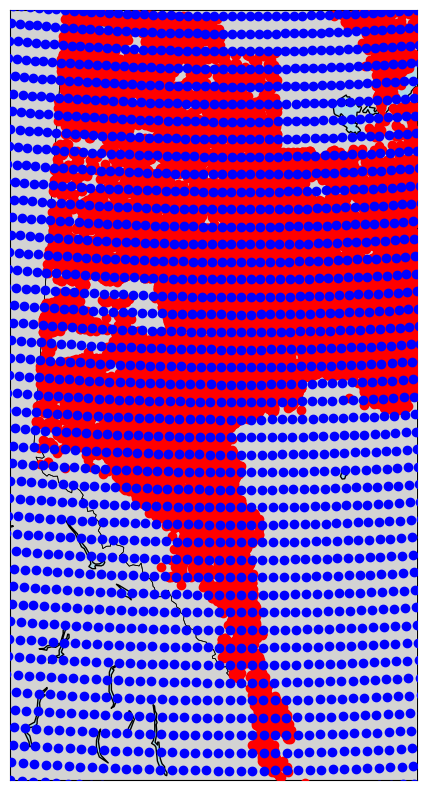

In [9]:
df = wildfires_df

fig = plt.figure(figsize=(10, 10))

# Create a Basemap of Alberta
# lat_0 and lon_0 are the center points of your map.
# llcrnrlat, urcrnrlat, llcrnrlon, and urcrnrlon set the lower-left and upper-right corners of the map in latitudes and longitudes respectively.
m = Basemap(projection='lcc', resolution='i',
            lat_0=55, lon_0=-115,
            llcrnrlon=-120, llcrnrlat=49, urcrnrlon=-110, urcrnrlat=60)

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # Draw states, might not work well outside of the USA
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Convert DataFrame latitude and longitude to map projection coordinates
x, y = m(df['longitude'].values, df['latitude'].values)

xw, yw = m(lons,lats)

# Plot points
m.scatter(x, y, marker='o', color='red', zorder=5)
m.scatter(xw, yw, marker='o', color='blue', zorder=5)

plt.show()

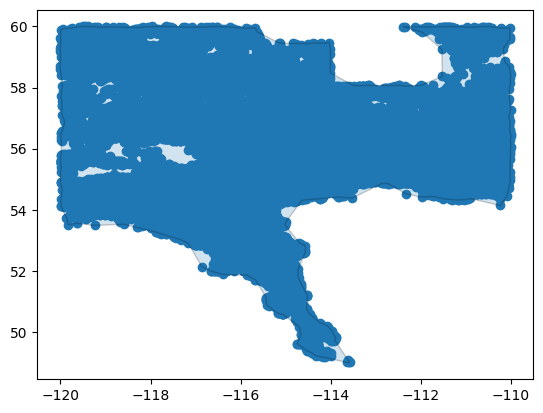

In [19]:
from scipy.spatial import ConvexHull
import alphashape
from descartes import PolygonPatch

points = wildfires_df[['longitude', 'latitude']].values  # Convert to required format

alpha_shape = alphashape.alphashape(points, 2)

fig, ax = plt.subplots()
ax.scatter(*zip(*points))
ax.add_patch(PolygonPatch(alpha_shape,alpha=0.2))
plt.show()

# Instead, assign fire points to the netcdf data then remove any points that had no associations

In [12]:
wildfires_df.groupby('general_cause').count()

,Unnamed: 0,id,fire_number,year,discovered_date,date,detection_agent_type,smoke_type,smoke_color,smoke_base_size,...,current_size,size_class,ia_getaway_obj,ia_start_size_obj,first_burn_period_obj,contained_size_obj,geometry,FA_NAME,forest_area,hour_of_day
general_cause,,,,,,,,,,,,,,,,,,,,,
Agriculture Industry,437,437,437,437,353,437,437,166,170,163,...,437,437,435,99,437,437,437,436,436,437
Forest Industry,640,640,640,640,452,640,640,110,111,107,...,640,640,468,180,640,640,640,640,640,640
Government,103,103,103,103,80,103,103,29,33,30,...,103,103,103,71,103,103,103,103,103,103
Incendiary,2434,2434,2434,2434,1969,2434,2434,742,757,717,...,2434,2434,2250,1825,2434,2434,2434,2431,2431,2434
Lightning,16836,16836,16836,16836,16301,16836,16836,7318,7452,6996,...,16836,16836,16254,16349,16836,16836,16836,16820,16820,16836
Miscellaneous Known,343,343,343,343,340,343,343,70,78,69,...,343,343,195,250,343,343,343,343,343,343
Oil & Gas Industry,496,496,496,496,389,496,496,168,175,156,...,496,496,427,164,496,496,496,496,496,496
Other Industry,1287,1287,1287,1287,1203,1287,1287,323,328,319,...,1287,1287,829,743,1287,1287,1287,1282,1282,1287
Power Line Industry,1126,1126,1126,1126,750,1126,1126,220,232,209,...,1126,1126,1086,496,1126,1126,1126,1126,1126,1126


In [13]:
print(wildfires_df['fire_type'].unique())
print(f'Number of nan entries: {wildfires_df["fire_type"].isna().sum()}')
print(f'Number of non-nan entries: {wildfires_df["fire_type"].count() - wildfires_df["fire_type"].isna().sum()}')

['Surface' 'Crown' 'Ground' '  Surface' '    Ground' '   Surface' nan]
Number of nan entries: 2
Number of non-nan entries: 33145


In [14]:
weather_stations = pd.read_csv("processed_weather_stations.csv")
weather_stations.info()
weather_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       486 non-null    int64  
 1   Unnamed: 0         486 non-null    int64  
 2   station_id         486 non-null    object 
 3   name               486 non-null    object 
 4   type               486 non-null    object 
 5   forecast_region    486 non-null    object 
 6   latitude           486 non-null    float64
 7   longitude          486 non-null    float64
 8   elevation_meters   486 non-null    float64
 9   geometry           486 non-null    object 
 10  natural_subregion  484 non-null    object 
 11  forest_area        486 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 45.7+ KB


,Unnamed: 0.1,Unnamed: 0,station_id,name,type,forecast_region,latitude,longitude,elevation_meters,geometry,natural_subregion,forest_area
0,0,1,AC,Adams Creek,LO,ED,53.725400,-118.568300,2177.63,POINT (264702.734833854 5956498.305364526),Alpine,Edson
1,1,2,AD,ADAIR,LO,OJ,59.160627,-118.329472,394.00,POINT (309732.8063132892 6560062.553724932),Northern Mixedwood,High Level
2,2,3,AE,Abee Agrd,MET,LB,54.277300,-112.965400,664.00,POINT (632417.3237908484 6013877.280879932),Dry Mixedwood,Lac La Biche
3,3,4,AF,Alder Flats,LO,RM,52.930000,-114.940300,960.00,POINT (504011.3600067233 5862138.586128435),Lower Foothills,Rocky Mountain
4,4,5,AKM,Akamina Pass,PAW,CR,49.027200,-114.053500,1809.00,POINT (569163.5691843902 5428737.765222042),Subalpine,Calgary


In [15]:
weather_readings = pd.read_csv("weather_readings.csv")
weather_readings.info()
weather_readings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619231 entries, 0 to 1619230
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1619231 non-null  int64  
 1   station_id            1619231 non-null  object 
 2   date                  1619231 non-null  object 
 3   update_timestamp      95630 non-null    object 
 4   dry_bulb_temperature  1619230 non-null  float64
 5   dew_point             1598191 non-null  float64
 6   relative_humidity     1598600 non-null  float64
 7   rain_mm               1619231 non-null  float64
 8   snow_cm               1619231 non-null  float64
 9   hail_mm               1619231 non-null  float64
 10  precipitation_mm      1619231 non-null  float64
 11  wind_speed_kmh        1619222 non-null  float64
 12  wind_gust_kmh         239645 non-null   float64
 13  wind_azimuth          1619231 non-null  int64  
 14  ffmc                  1126667 non-

,Unnamed: 0,station_id,date,update_timestamp,dry_bulb_temperature,dew_point,relative_humidity,rain_mm,snow_cm,hail_mm,...,wind_speed_kmh,wind_gust_kmh,wind_azimuth,ffmc,dmc,dc,isi,bui,fwi,dsr
0,1,AC,1974-05-19,2004-01-08 15:01:41,NaN,NaN,NaN,0.00,0.0,0.0,...,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,AC,1974-05-20,2004-01-08 15:01:41,2.78,-4.4,56.0,0.00,0.0,0.0,...,5.0,NaN,135,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,AC,1974-05-22,2004-01-08 15:01:41,4.44,-4.4,50.0,0.00,0.0,0.0,...,32.0,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AC,1974-05-23,2004-01-08 15:01:41,0.00,0.0,100.0,0.00,0.0,0.0,...,8.0,NaN,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,AC,1974-05-24,2004-01-08 15:01:41,2.78,-2.2,69.0,0.76,0.0,0.0,...,39.0,NaN,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
